In [7]:
import numpy as np
from scipy.signal import fftconvolve
from collections import deque
from skimage.draw import disk
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal

from sklearn import linear_model
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from patsy import dmatrix
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [27]:
def display_images(template, science, difference, title, scale='5sigma'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    title_ls = ['template', 'science', 'diff']
    if scale == 'zscale':
        ax[0].imshow(interval(template), cmap='gray', origin='lower')
        ax[1].imshow(interval(science), cmap='gray', origin='lower')
        ax[2].imshow(interval(difference), cmap='gray', origin='lower')
    else:
        m = difference.mean()
        std = difference.std()
        ax[0].imshow(template, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[1].imshow(science, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[2].imshow(difference, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
    for i in range(3): ax[i].set_axis_off() 
    for i in range(3): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=0.65)
    
def display_images_and_mask(template, science, difference, mask, title, scale='5sigma', figsize=(15, 15)):
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    title_ls = ['template', 'science', 'diff', 'mask']
    if scale == 'zscale':
        ax[0].imshow(interval(template), cmap='gray', origin='lower')
        ax[1].imshow(interval(science), cmap='gray', origin='lower')
        ax[2].imshow(interval(difference), cmap='gray', origin='lower')
        ax[3].imshow(mask, cmap='gray', origin='lower')
    else:
        m = difference.mean()
        std = difference.std()
        ax[0].imshow(template, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[1].imshow(science, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[2].imshow(difference, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[3].imshow(mask, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
    for i in range(4): ax[i].set_axis_off() 
    for i in range(4): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=0.65)
    
def compare_to_dia_pipe(template, science, dia_pipe, difference, title, scale='zscale', figsize=(15, 15)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    ax = axes.flat
    title_ls = ['template', 'science', 'dia pipe', 'diff']
    if scale == 'zscale':
        ax[0].imshow(interval(template), cmap='gray', origin='lower')
        ax[1].imshow(interval(science), cmap='gray', origin='lower')
        ax[2].imshow(interval(dia_pipe), cmap='gray', origin='lower')
        ax[3].imshow(difference, cmap='gray', origin='lower')
    else:
        m = difference.mean()
        std = difference.std()
        ax[0].imshow(template, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[1].imshow(science, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[2].imshow(dia_pipe, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[3].imshow(difference, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
    for i in range(4): ax[i].set_axis_off() 
    for i in range(4): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=1)
    
def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

def Gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

##################
# simulate images
def sim_spatially_varying_sigma(x, y, sigma, T=20, alpha=0.):
    sigma_x = sigma + alpha * np.sin(2 * np.pi / T * x) * sigma
    sigma_y = sigma + alpha * np.sin(2 * np.pi / T * y) * sigma
    return sigma_x, sigma_y

def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_star(x_size, y_size, x, y, flux, psf_sig):
    image_xx, image_yy = compute_xy_grids(x_size, y_size)
    star_im = flux * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[psf_sig, 0], [0, psf_sig]]
        )
    return star_im

def sim_image(image_size, sky_sig, psf_sig, source_catalog, T=20, alpha=0.1):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']

    for i in range(len(fluxes)):
        x, y = x_pos[i], y_pos[i]
        sigma_x, sigma_y = sim_spatially_varying_sigma(x, y, psf_sig, T=T, alpha=alpha)
        image += fluxes[i] * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[sigma_x, 0], [0, sigma_y]]
        )
    return image
#################################################

    
def ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg):
    # compute Gaussian
    gau = Gaussian2d(xx, yy, cov=gauss_cov)
    # compute Chebyshev
    x_deg, y_deg = poly_deg[0], poly_deg[1]
    coef_x = np.zeros(x_deg + 1)
    coef_x[x_deg] = 1
    coef_y = np.zeros(y_deg + 1)
    coef_y[y_deg] = 1
    coefs = np.outer(coef_x, coef_y)
    cheb = chebval2d(xx, yy, c=coefs)
    return cheb * gau

def normalize_bases(bases):
    b0 = None
    normalized_bases = deque()
    for b in bases:
        kernel_sum = b.sum()
        if kernel_sum > 1e-9:
            basis = b / kernel_sum
            if b0 is None:
                b0 = basis
                continue
            else:
                basis -= b0
        else:
            basis = b
        normalized_bases.append(basis)
    normalized_bases.appendleft(b0)
    return list(normalized_bases)
    
def ChebyshevGaussianBases(kernel_size=31, gaussian_sigmas=[0.75, 1.5, 3.0], poly_degrees= [4, 2, 2]):
    xx, yy = compute_xy_grids(kernel_size, kernel_size)
    kernel_bases = []
    for id_x, x_sig in enumerate(gaussian_sigmas):
        for id_y, y_sig in enumerate(gaussian_sigmas):
            for x_deg in range(poly_degrees[id_x]+1):
                for y_deg in range(poly_degrees[id_y]+1):
                    gauss_cov = [[x_sig, 0.], [0., y_sig]]
                    poly_deg = (x_deg, y_deg)
                    kernel_basis = ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg)
                    kernel_bases.append(kernel_basis)
    return kernel_bases

def DeltaBases(kernel_size=11):
    kernel_bases = []
    for i in range(kernel_size):
        for j in range(kernel_size):
            basis = np.zeros((kernel_size, kernel_size))
            basis[i][j] = 1
            kernel_bases.append(basis)
    return kernel_bases

def PolyModel(x_size, y_size, degree):
    xx, yy = compute_xy_grids(x_size, y_size)
    xx, yy = xx / x_size, yy / y_size
    spatial_images = []
    for current_deg in range(0, degree + 1):
        for x_deg in range(current_deg + 1):
            y_deg = current_deg - x_deg 
            coef_x = np.zeros(x_deg + 1)
            coef_x[x_deg] = 1
            coef_y = np.zeros(y_deg + 1)
            coef_y[y_deg] = 1
            coefs = np.outer(coef_x, coef_y)
            spatial_image = polyval2d(xx, yy, c=coefs)
            spatial_images.append(spatial_image)
    spatial_images
    return spatial_images

def BsplinesModel(x_size, y_size, dof):
    dof = 3
    xx, yy = compute_xy_grids(x_size, y_size)
    bsplines = dmatrix("te(cr(xx, dof), cc(yy, dof)) - 1", {"xx": xx.ravel(), "yy": yy.ravel(), "dof": dof})
    kernel_bases = []
    for i in range(bsplines.shape[1]):
        basis = bsplines[:, i]
        kernel_bases.append(basis.reshape(y_size, x_size))
    return kernel_bases

def _compute_base_vecs(template, kernel_bases):
    base_vecs = []
    for basis in kernel_bases:
        base_im = fftconvolve(template, basis, mode='same')
        base_vecs.append(base_im.flatten())
    base_vecs = np.vstack(base_vecs).T   
    return base_vecs
"""
def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for i in range(base_vecs.shape[1]):
        base_vec = base_vecs[:, i]
        if constant_scaling and i == 0:
            base_spatial_vecs.append(base_vec)
            continue
        for j in range(len(spatial_images)):
            spatial_vec =  spatial_images[j].flatten()
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs
"""

def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for j in range(len(spatial_images)):
        spatial_vec = spatial_images[j].flatten()
        for i in range(base_vecs.shape[1]):
            base_vec = base_vecs[:, i]
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs    

def CircularMask(r_size, c_size, r, c, radius):
    mask = np.zeros((r_size, c_size))
    rr, cc = disk((r, c), radius)
    mask[rr, cc] = 1
    mask = mask.astype('bool')
    return mask

def AlardLuptonAlgorithm(template, science, kernel_bases, spatial_model, bg_model, regressor, mask=None, constant_scaling=True):
    if constant_scaling:
        kernel_bases = normalize_bases(kernel_bases)
        print('kernel bases normalized')
    base_vecs = _compute_base_vecs(template, kernel_bases)
    base_spatial_vecs = _compute_base_spatial_vecs(base_vecs, spatial_model, constant_scaling=constant_scaling)
    bg_vecs = np.vstack([bg.flatten() for bg in bg_model]).T        
    X = np.concatenate((base_spatial_vecs, bg_vecs), axis=1)
    y = science.flatten()
    if mask is not None:
        X_ma = X[~mask.flatten()]
        y_ma = y[~mask.flatten()]
        regressor.fit(X_ma, y_ma)
    else:
        regressor.fit(X, y)
    y_pred = regressor.predict(X)
    difference = science - y_pred.reshape(template.shape)
    return difference, regressor, X, y 

# DC2 Images

In [9]:
import lsst.afw.image as afwImage
import data_process_utils as dpu
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from lsst.afw.table import BaseCatalog

SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
SHAPE_FLAGS = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']

data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'

coadd = afwImage.ExposureF(f'{data_dir}/patch_0to6/diff/dipole_examples/coadd/coadd_4639_00.fits')
calexp = afwImage.ExposureF(f'{data_dir}/patch_0to6/injection/00_20_21_1013665_79_i/fake_20/calexp/01013665-i/R20/calexp_01013665-i-R20-S21-det079.fits')
al_diff = afwImage.ExposureF(f'{data_dir}/patch_0to6/diff/dipole_examples/al/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

diaSrc = BaseCatalog.readFits(f'{data_dir}/patch_0to6/diff/dipole_examples/al/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diaSrc = diaSrc.asAstropy()

non_saturation = dpu.remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)

coadd_warped = dpu.warp_to_exposure(coadd, calexp)
diff_warped = dpu.warp_to_exposure(al_diff, calexp)

In [43]:
def diaSrc_analysis(source_id, coadd, calexp, diff, diaSrc_table, crop_size, sdof, title):
    crop_size = crop_size
    x, y = int(diaSrc_table[source_id]['base_NaiveCentroid_x']), int(diaSrc_table[source_id]['base_NaiveCentroid_y'])
    delta = int(crop_size / 2)
    coadd_cropped = coadd.getImage().array[y-delta:y+delta, x-delta:x+delta]
    calexp_cropped = calexp.getImage().array[y-delta:y+delta, x-delta:x+delta]
    diff_cropped = diff.getImage().array[y-delta:y+delta, x-delta:x+delta]

    difference, regressor, X, y = AlardLuptonAlgorithm(
        template = coadd_cropped,
        science = calexp_cropped, 
        mask = None,
        kernel_bases = ChebyshevGaussianBases(kernel_size=31, gaussian_sigmas=[0.75, 1.5, 3.0], poly_degrees= [4, 2, 2]),
        spatial_model = PolyModel(x_size=coadd_cropped.shape[1], y_size=coadd_cropped.shape[0], degree=sdof), 
        bg_model = PolyModel(x_size=coadd_cropped.shape[1], y_size=coadd_cropped.shape[0], degree=1),
        regressor=linear_model.LinearRegression(), 
        constant_scaling=True)
    compare_to_dia_pipe(template=coadd_cropped, science=calexp_cropped, dia_pipe=diff_cropped, difference=difference, title=title, scale='zscale', figsize=(8,8))

In [ ]:
5, 8, 21, 22, 25

kernel bases normalized


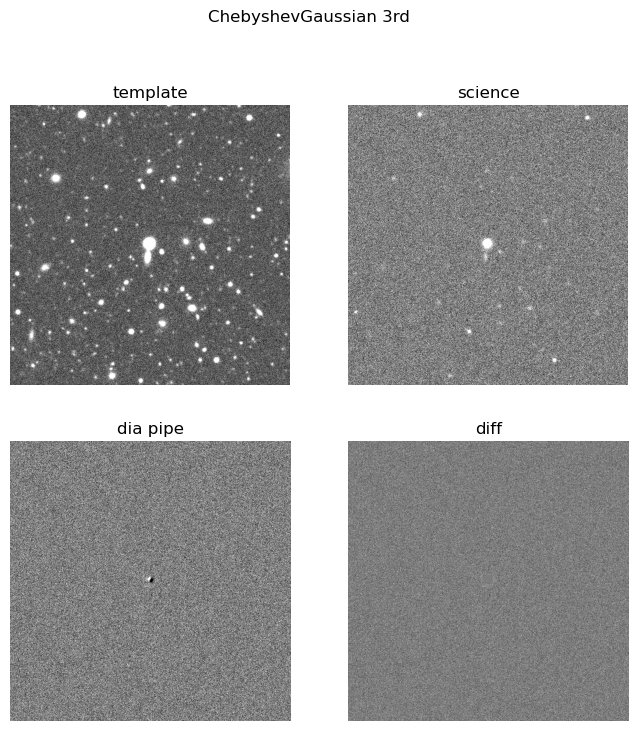

In [44]:
diaSrc_analysis(source_id=5, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=600, sdof=3, title='ChebyshevGaussian 3rd')

kernel bases normalized


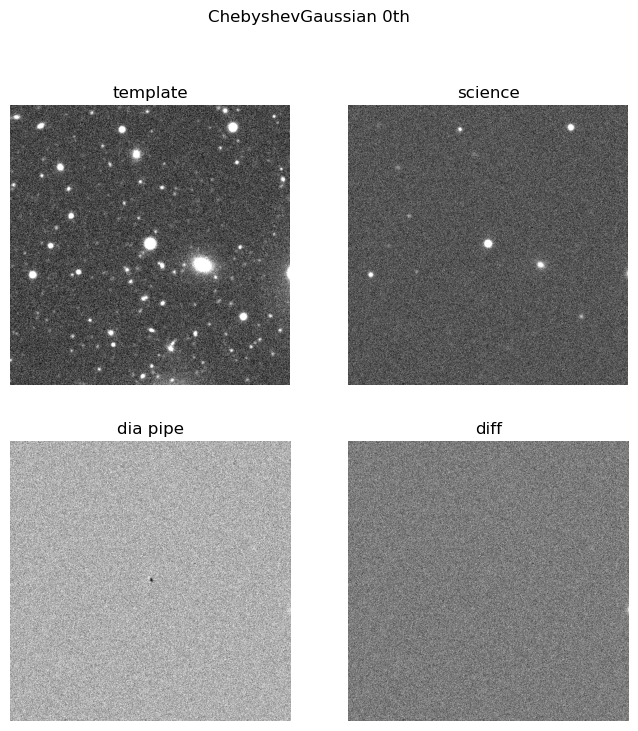

In [47]:
diaSrc_analysis(source_id=8, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=500, sdof=0, title='ChebyshevGaussian 0th')

kernel bases normalized


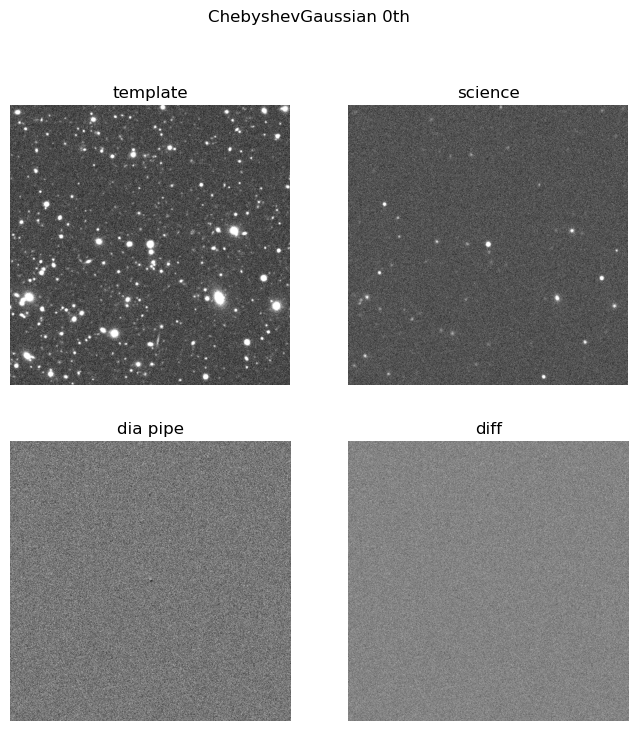

In [49]:
diaSrc_analysis(source_id=21, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=800, sdof=0, title='ChebyshevGaussian 0th')

kernel bases normalized


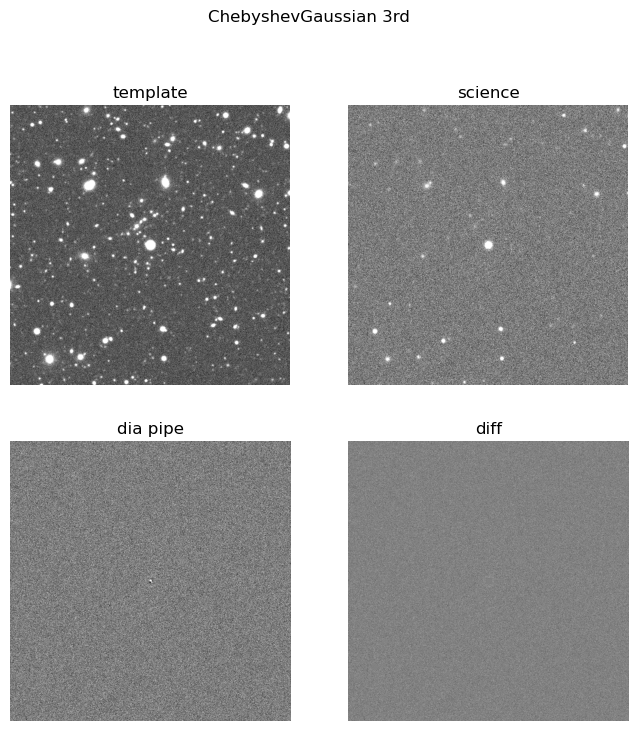

In [51]:
diaSrc_analysis(source_id=22, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=800, sdof=3, title='ChebyshevGaussian 3rd')

kernel bases normalized


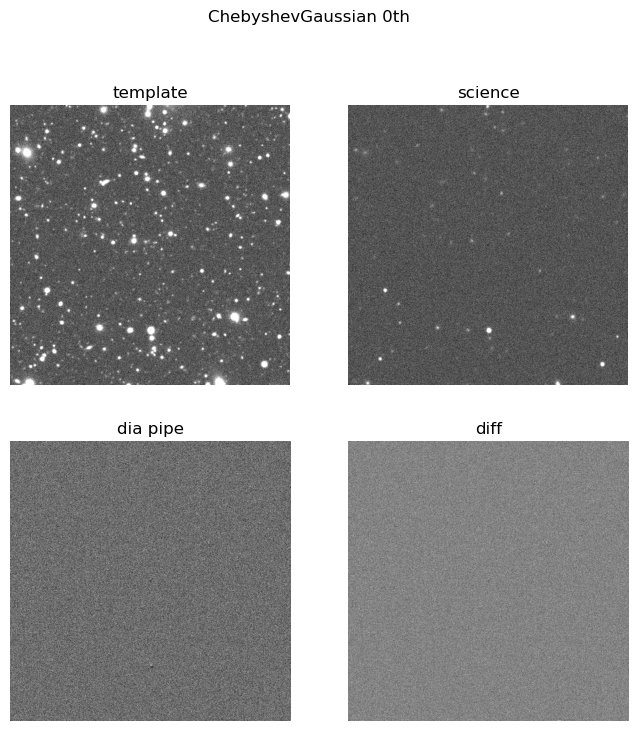

In [52]:
diaSrc_analysis(source_id=23, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=800, sdof=0, title='ChebyshevGaussian 0th')

kernel bases normalized


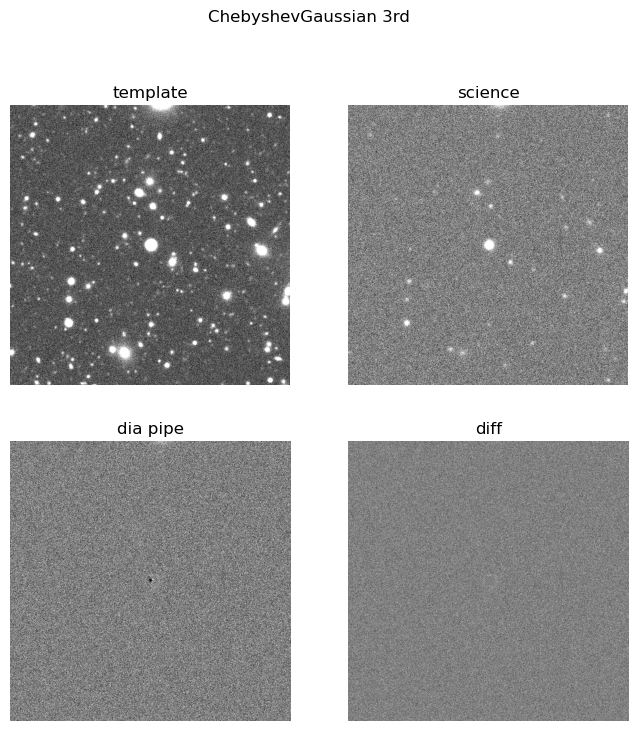

In [55]:
diaSrc_analysis(source_id=25, coadd=coadd_warped, calexp=calexp, diff=diff_warped, diaSrc_table=non_saturation, crop_size=600, sdof=3, title='ChebyshevGaussian 3rd')

kernel bases normalized


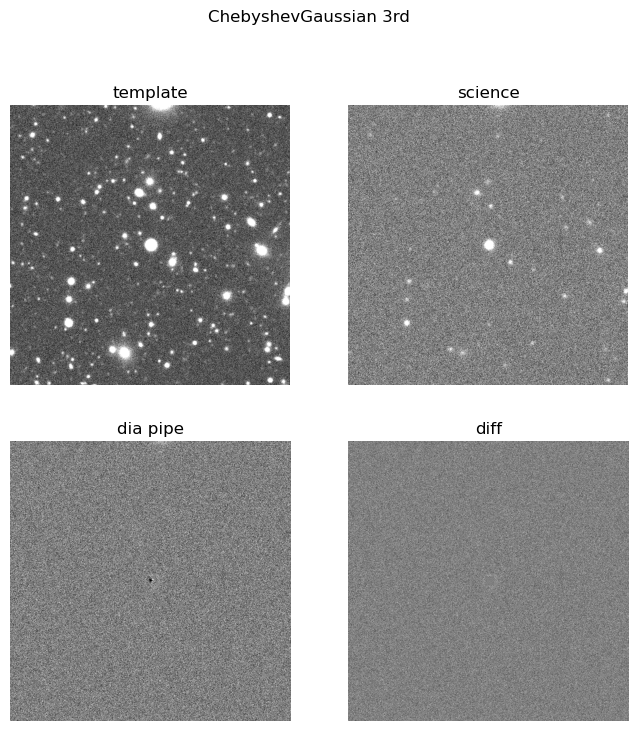

In [54]:
source_id = 25
crop_size = 600
x, y = int(non_saturation[source_id]['base_NaiveCentroid_x']), int(non_saturation[source_id]['base_NaiveCentroid_y'])
delta = int(crop_size / 2)
coadd_cropped = coadd_warped.getImage().array[y-delta:y+delta, x-delta:x+delta]
calexp_cropped = calexp.getImage().array[y-delta:y+delta, x-delta:x+delta]
diff_cropped = diff_warped.getImage().array[y-delta:y+delta, x-delta:x+delta]

difference, regressor, X, y = AlardLuptonAlgorithm(
    template = coadd_cropped,
    science = calexp_cropped, 
    mask = None,
    kernel_bases = ChebyshevGaussianBases(kernel_size=31, gaussian_sigmas=[0.75, 1.5, 3.0], poly_degrees= [4, 2, 2]),
    spatial_model = PolyModel(x_size=coadd_cropped.shape[1], y_size=coadd_cropped.shape[0], degree=3), 
    bg_model = PolyModel(x_size=coadd_cropped.shape[1], y_size=coadd_cropped.shape[0], degree=3),
    regressor=linear_model.LinearRegression(), 
    constant_scaling=True)
compare_to_dia_pipe(template=coadd_cropped, science=calexp_cropped, dia_pipe=diff_cropped, difference=difference, title='ChebyshevGaussian 3rd', scale='zscale', figsize=(8,8))